
# Project Description

**Objectives:** Predict the probability of a purchase within the next 90 days. 

**Plan of Action**
1. Exploring the Data
    - Load three datasets: purchases, messages, and target.

    - Conduct a basic analysis:

        - Check the size and structure of the datasets.

        - Identify missing values, duplicates, and invalid data.

        - Remove duplicates where necessary.

        - Study the numerical and categorical features.
    
    - Create features that capture user behavior, engagement with campaigns, product categories, and other relevant aspects.

    - Check class imbalance and apply balancing techniques (e.g., oversampling or undersampling) if necessary.

2. Data Preparation

    - Combine data from all sources using client_id.

3. Modelling 
    - Use different machine learning models to maximize ROC-AUC score (should be greater that 0.7).

4. Analyze the best model using confusion matrix.

5. Analyze feature importance and potential clients.

# 0. Notebook Set-up

**Imports**

In [812]:
pip install -q phik


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [813]:
pip install -q shap


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [814]:
# Standard libraries 
import pandas as pd
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

# Third  party libs
from ast import literal_eval
from phik import phik_matrix
import shap

# ML
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Boosting
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

**Functions**

In [815]:
# Function to display the main information about a data frame
def display_main_info(df):
    print('________________Head________________')
    display(df.head())
    print('________________Data Types Info________________')
    display(df.info())
    print('________________Shape________________')
    display(df.shape)
    print('________________Duplicates________________')
    display(df.duplicated().sum())
    print('________________Proportion of Missing Data________________')
    display(df.isna().mean())

In [816]:
# Function to displays statistical info
def show_stats(df, column_name: str):
    print(f'Statics for {column_name}')
    display(df[[column_name]].describe().T)

In [817]:
# Function that plots a histogram
def plot_histogram(df, column_name):
    
    plt.figure(figsize=(10, 6))
    
    sns.histplot(
        df[column_name],
        bins=20,  
        kde=True,  
        color='green', 
        stat='density',  
        line_kws={'color': 'black', 'lw': 2} 
    )
    
    plt.title(f'Distribution of {column_name}', fontsize=14)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.tight_layout()
    plt.show()

In [818]:
# Function that plots a histogram and a box plot
def plot_hist_box(df, col_name: str):
    f, (ax_box, ax_hist) = plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios": (.15, .85)},
        figsize=(8, 6)
    )

    sns.set(style="whitegrid")
    sns.boxplot(df[col_name], orient="h", ax=ax_box)
    sns.histplot(df[col_name], ax=ax_hist, kde=True)
    ax_box.set(xlabel='')
    plt.suptitle(f'Distribution of {col_name}', fontsize=14)
    plt.show()

In [819]:
# Function that plots a confusion matrix and ROC-AUC score

def evaluate_model(model, X_test, y_test, threshold=0.5):
    
    predictions = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, predictions)
    print(f'ROC-AUC on test: {roc_auc:.4f}')
    
    y_pred = (predictions >= threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [820]:
# Function that calculates and outputs Recall

def calculate_recall(model, X_test, y_test):
    binary_predictions = model.predict(X_test)
    recall = recall_score(y_test, binary_predictions)
    print(f'Recall on test: {recall:.4f}')

Constants

In [821]:
RANDOM_STATE = 42

# 1. Exploring the Data

## 1.1 Load Data

In [822]:
purchases = pd.read_csv('/apparel-purchases.csv', parse_dates=['date'])

In [823]:
dates = ['date', 'created_at']
messages = pd.read_csv('/apparel-messages.csv', parse_dates=dates)

In [824]:
target = pd.read_csv('/apparel-target_binary.csv')

## 1.2 Purchases

### 1.2.1 Basic Information

In [825]:
display_main_info(purchases)

________________Head________________


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


None

________________Shape________________


(202208, 6)

________________Duplicates________________


73020

________________Proportion of Missing Data________________


client_id       0.0
quantity        0.0
price           0.0
category_ids    0.0
date            0.0
message_id      0.0
dtype: float64

**Observations:**
- All data types are stated correctly.

- No missing data in this data set.

- The number of exact duplicates is 73020 which will be dealt with further on.

In [826]:
# Number of unique clients
purchases['client_id'].nunique()

49849

### 1.2.2 Deduplication

- The exact duplicates were likely caused by repetitive imports or merging operations.

- Such duplicates can inflate counts, totals, averages etc.

- Since there is no way to identify why duplicates exist I will remove them.

In [827]:
purchases = purchases.drop_duplicates()

In [828]:
purchases.duplicated().sum()

0

In [829]:
# Check the duplicates in Primary Key
purchases['client_id'].duplicated().sum()

79339

- These could represent **multiple purchases** by the same clients.

- The duplicates are legitimate so I will aggregate their transactions for modelling.

### 1.2.3 Date

Since date-related information is highly important in analizing customer behavour, I will start with analyzing the date column.

**A. Overview**

In [830]:
show_stats(purchases, 'date')

Statics for date


,count,mean,min,25%,50%,75%,max
date,129188,2023-02-26 07:40:09.771805440,2022-05-16 00:00:00,2022-09-09 00:00:00,2023-03-22 00:00:00,2023-06-28 00:00:00,2024-02-16 00:00:00


**Observations:**
- The dataset spans from **May 2022 to February 2024**, with a noticeable concentration of purchases between late 2022 and early 2023, judging by the median and quartiles.

- Since the most recent purchases occurred in February 2024, it indicates that there’s an ongoing stream of purchases, and the dataset is being actively updated.

- The dates look good. There seems to be no errors or invalid data in this column.

**B. Extract Day, Month, and Year**

In [831]:
purchases['day_of_week'] = purchases['date'].dt.day_of_week
purchases['day_of_month'] = purchases['date'].dt.day
purchases['month'] = purchases['date'].dt.month
purchases['year'] = purchases['date'].dt.year

In [832]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,day_of_week,day_of_month,month,year
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,16,5,2022
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,16,5,2022
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022


In [833]:
# Double check the data is correct

date_cols = ['day_of_week',	'day_of_month', 'month', 'year'] 

for date in date_cols:
    print(f'========Unique values of {date}========\n')
    print(purchases[date].unique())

========Unique values of day_of_week========

[0 1 2 3 4 5 6]
========Unique values of day_of_month========

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8
  9 10 11 12 13 14 15]
========Unique values of month========

[ 5  6  7  8  9 10 11 12  1  2  3  4]
========Unique values of year========

[2022 2023 2024]


In [834]:
for date in date_cols:
    print(f'========Distribution of {date}=========')
    display(purchases[date].value_counts(normalize=True))

========Distribution of day_of_week=========


day_of_week
4    0.258685
2    0.167454
5    0.152220
3    0.141902
1    0.112874
6    0.085201
0    0.081664
Name: proportion, dtype: float64

========Distribution of day_of_month=========


day_of_month
11    0.052288
10    0.047628
12    0.043688
29    0.039926
15    0.039439
22    0.038835
23    0.038030
13    0.037759
16    0.037503
9     0.036784
14    0.036458
2     0.036226
3     0.035506
28    0.034353
30    0.032673
4     0.032046
5     0.031930
20    0.030258
1     0.029778
6     0.028013
24    0.027611
21    0.027534
27    0.026171
8     0.026016
19    0.025862
17    0.024685
7     0.024035
26    0.023075
25    0.022812
18    0.020830
31    0.012246
Name: proportion, dtype: float64

========Distribution of month=========


month
6     0.209911
12    0.132597
11    0.118966
7     0.109631
8     0.078258
4     0.077205
5     0.075990
3     0.055493
9     0.047860
1     0.046839
2     0.028153
10    0.019096
Name: proportion, dtype: float64

========Distribution of year=========


year
2023    0.504567
2022    0.444538
2024    0.050895
Name: proportion, dtype: float64

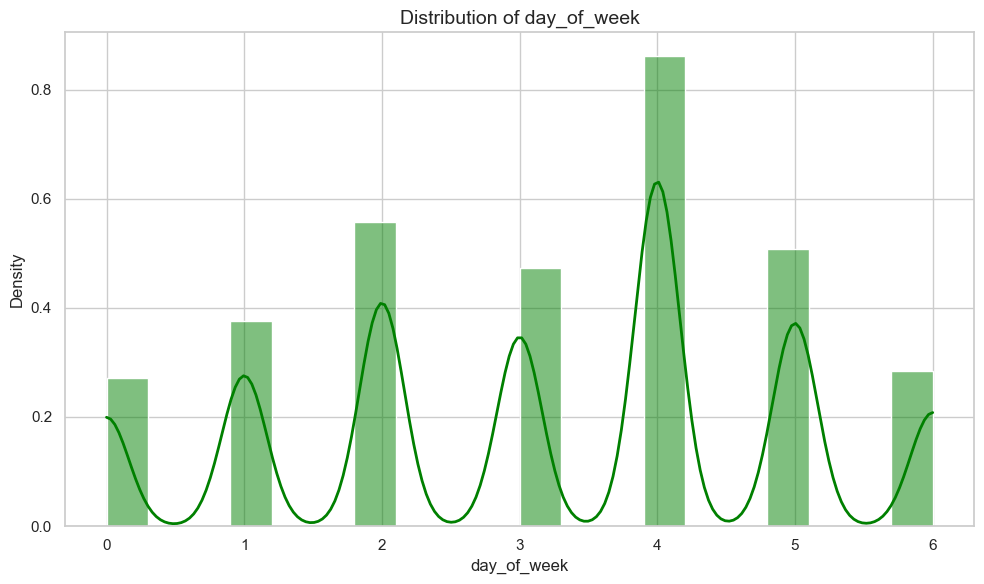

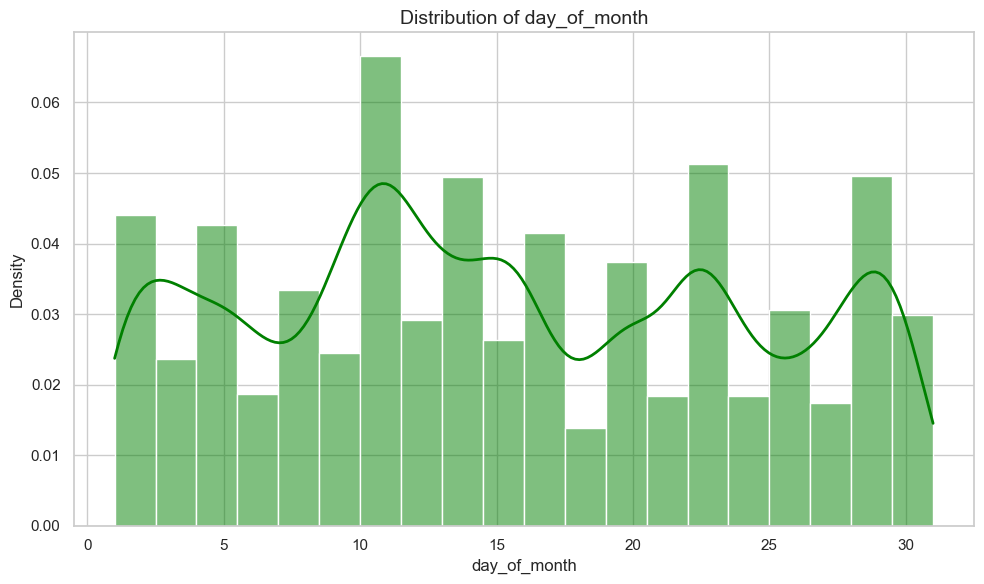

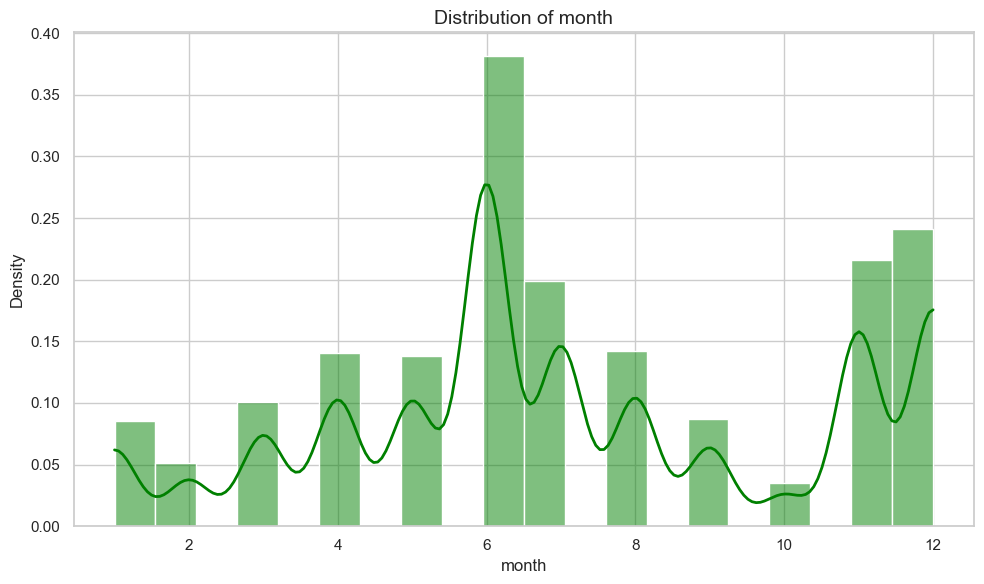

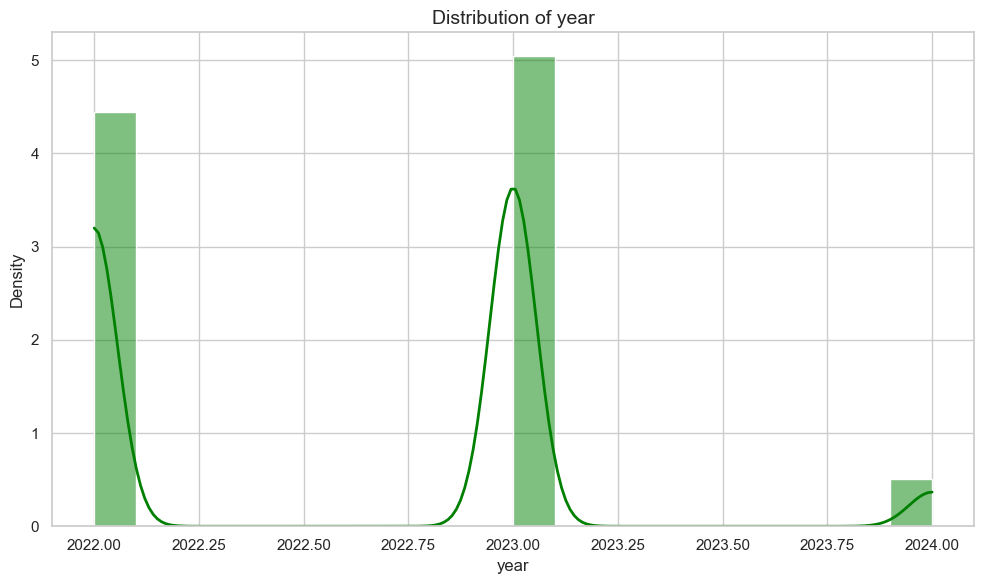

In [835]:
for date in date_cols:
    plot_histogram(purchases, date)

**Observations:**

**A. Days of Week:**
- Friday (25.87%): The most frequent day for purchases, likely due to the start of the weekend and potentially promotional campaigns aligning with this.

- Wednesday (16.75%) and Saturday (15.22%): Moderate activity days, with Saturday potentially benefiting from weekend shopping habits.

- Sunday (8.17%): Lowest activity day, possibly reflecting a day of rest or fewer campaigns targeting this day.

**B. Days of Month:**
- Peak Days:

    - The 11th (5.23%), followed by the 10th (4.76%) and 12th (4.37%).
    
    - This suggests mid-month days are slightly more active, which might align with payment schedules or other cyclical consumer behaviors.

- End-of-Month:

    - The 29th and 30th show slightly elevated activity (3.99% and 3.27%, respectively).

- Even Distribution Otherwise:

    - Most other days fall within a close range of ~2.5% to 3.7%.

**B. Months:**

- June (20.99%): Peaks, possibly tied to summer campaigns, seasonal sales, or back-to-school promotions.

- December (13.26%): High activity aligns with holiday shopping and end-of-year sales.

- November (11.90%): Likely influenced by events like Black Friday and early holiday shopping.

- October (1.91%): Low frequency may indicate a gap in promotional activity or a natural lull in shopping trends.

**C. Year:**

- 2023 (50.46%): The bulk of purchases occurred in this year, indicating recent, potentially robust customer activity.

- Current Year (2024): 5.09%: The current year’s lower proportion likely reflects incomplete data.

**C. Calculate Recency**

For the future analizis at customer level it will be helpfull to analize when the most recent purchase was made. I will therefore add a new feature reflecting that.

Since the dataset is regularily updated, I will use the latest date as the date data was pulled.

In [836]:
PULL_DATE = purchases['date'].max()

In [837]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,day_of_week,day_of_month,month,year
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,16,5,2022
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,16,5,2022
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022


**D. Calculate Purchase Frequency**

It is also important to measure how often a client purchases because an active customer is likely to return. 
I will add a binary feature if the purchase was made within the last 30 days to count the number of such purchases later.

In [838]:
LAST_30_DAYS = PULL_DATE - pd.Timedelta(days=30)

purchases['nr_purchases_last_30_days'] = purchases['date'].apply(lambda x: 1 if x >= LAST_30_DAYS else 0)

**E. Aggregate Features by Client**

In [839]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,day_of_week,day_of_month,month,year,nr_purchases_last_30_days
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,16,5,2022,0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,16,5,2022,0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022,0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022,0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022,0


In [840]:
dates_features = purchases.groupby('client_id').agg(
    {
        'date': 'max',
        'day_of_week': lambda x: x.mode()[0],
        'day_of_month': lambda x: x.mode()[0],
        'month': lambda x: x.mode()[0],
        'nr_purchases_last_30_days': 'sum'
    }
).reset_index()

In [841]:
dates_features.head()

,client_id,date,day_of_week,day_of_month,month,nr_purchases_last_30_days
0,1515915625468060902,2022-05-27,4,27,5,0
1,1515915625468061003,2023-01-04,2,4,1,0
2,1515915625468061099,2022-05-17,1,17,5,0
3,1515915625468061100,2024-02-10,5,10,2,1
4,1515915625468061170,2023-06-17,2,29,3,0


### 1.2.4 Categories

**A. Overview**

In [842]:
# Number of unique combinations
purchases['category_ids'].nunique()

933

In [843]:
# Most popular categories sequence
purchases['category_ids'].value_counts(normalize=True)

category_ids
['4', '28', '57', '431']            0.047922
['4', '28', '244', '432']           0.037426
['4', '28', '260', '420']           0.034221
['4', '28', '275', '421']           0.025614
['2', '18', '258', '441']           0.024577
                                      ...   
['4', '27', '336', '1854']          0.000008
['4', '44', '1600']                 0.000008
['4', '27', '353', '1799']          0.000008
['5963', '5959', '6021', '999']     0.000008
['5562', '5597', '5642', '1218']    0.000008
Name: proportion, Length: 933, dtype: float64

In [844]:
# Converting to python list
purchases['category_ids'] = purchases['category_ids'].apply(literal_eval)

In [845]:
# Add list length
purchases['cat_len'] = purchases['category_ids'].apply(lambda x: len(x))

In [846]:
purchases['cat_len'].value_counts(normalize=True)

cat_len
4    0.965624
0    0.021194
3    0.005697
1    0.004815
5    0.002671
Name: proportion, dtype: float64

**Observations:**

- There are 933 unique combinations of categories with the most popular and the least popular sequences being **['4', '28', '57', '431']** and **['5562', '5597', '5642', '1218']** respectively. This info could be an insight for marketing analysis if required.

- Most transactions have **4** categories, making up about **96.56%** of all transactions.

- A small fraction have no categories, which indicates missing or invalid data in the category_ids column.

- Other cat_len values (e.g., 3, 1, 5) are relatively rare.

**B. Missing information**

I will first have a look at the data which has 0 & 1 in category_ids

In [847]:
purchases[purchases['cat_len'] == 0].head()

,client_id,quantity,price,category_ids,date,message_id,day_of_week,day_of_month,month,year,nr_purchases_last_30_days,cat_len
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7,5,9,7,2022,0,0
49215,1515915625474537721,1,7.0,[],2022-11-12,1515915625474537721-7803-636dfed5eb8b6,5,12,11,2022,0,0
53223,1515915625720375281,1,5.0,[],2022-11-13,1515915625720375281-7818-636f6ec29a382,6,13,11,2022,0,0
59056,1515915625867975448,1,7.0,[],2022-11-16,1515915625766044118-7879-63748749d81b5,2,16,11,2022,0,0
60268,1515915625489294901,1,7.0,[],2022-11-23,1515915625489294901-8033-637dbe1f75aa9,2,23,11,2022,0,0


In [848]:
purchases[purchases['cat_len'] == 1].head()

,client_id,quantity,price,category_ids,date,message_id,day_of_week,day_of_month,month,year,nr_purchases_last_30_days,cat_len
14848,1515915625649908756,1,2499.0,[None],2022-06-17,1515915625649908756-4981-62ac2dbf52fad,4,17,6,2022,0,1
32281,1515915625578652401,1,8.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f,4,19,8,2022,0,1
32283,1515915625578652401,1,1.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f,4,19,8,2022,0,1
33447,1515915625468141353,1,7.0,[None],2022-08-25,1515915625468141353-5922-62ff3544b2556,3,25,8,2022,0,1
33982,1515915625468112307,1,3.0,[None],2022-08-29,1515915625468112307-6223-630c9088d251c,0,29,8,2022,0,1


It appears to be missing data. Since it's only a small fraction, I will remove it from the dataset.

_It could however be filled with the average category based on the mean price value. Not quite sure if that's worth the effort though._

In [849]:
# Filter out the missing categories 
purchases = purchases[purchases['cat_len'] > 1]

**C. Categories analysis** 

I will have a look at the categories and subcategories separately.

In [850]:
# Create a df with categories

max_len = purchases['cat_len'].max()

categories = pd.DataFrame(
    columns=[f'cat_{i+1}' for i in range(max_len)],
    data=purchases['category_ids'].tolist()
)

In [851]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125828 entries, 0 to 125827
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   cat_1   125828 non-null  object
 1   cat_2   125828 non-null  object
 2   cat_3   125828 non-null  object
 3   cat_4   125092 non-null  object
 4   cat_5   345 non-null     object
dtypes: object(5)
memory usage: 4.8+ MB


In [852]:
categories.describe()

,cat_1,cat_2,cat_3,cat_4,cat_5
count,125828,125828,125828,125092,345
unique,8,31,291,838,1
top,4,28,57,431,467
freq,73428,53564,6191,6191,345


**Observations:**

- **cat_1:**

    - Has a relatively small number of unique categories (8), and the top category 4 appears frequently. 

    - This suggests that most customers tend to purchase items from a few common categories, which may make it _a strong feature_ for classification.

- **cat_2:**

    - With 31 unique categories and 28 as the most frequent, this column provides a bit more variety than cat_1. 

    - However, the frequency of the most common category (53564) is still significant, indicating some categories dominate.

- **cat_3 and cat_4:**

    - These columns have many more unique categories. 

    - Would require more preprocessing to avoid high sparsity so I will not use them for modelling.

- **cat_5:**

    - Only one unique value, and would not provide any useful information.

**D. Selecting categories**

I will use cat_1 as the main category and cat_2 as a subcategory.

In [853]:
purchases['main_category'] = purchases['category_ids'].apply(lambda x: x[0]).astype(int)
purchases['subcategory'] = purchases['category_ids'].apply(lambda x: x[1]).astype(int)

In [854]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,day_of_week,day_of_month,month,year,nr_purchases_last_30_days,cat_len,main_category,subcategory
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,0,16,5,2022,0,4,4,28
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,0,16,5,2022,0,4,4,28
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022,0,4,4,28
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022,0,4,4,28
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,0,16,5,2022,0,4,4,28


**E. Aggregating**

In [855]:
category_features = purchases.groupby('client_id').agg(
    main_category_mode=('main_category', lambda x: x.mode()[0]),
    subcategory_mode=('subcategory', lambda x: x.mode()[0])
).reset_index()

In [856]:
category_features.head()

,client_id,main_category_mode,subcategory_mode
0,1515915625468060902,4,28
1,1515915625468061003,4,28
2,1515915625468061099,4,28
3,1515915625468061100,4,27
4,1515915625468061170,4,28


### 1.2.4 Quantity

**A. Overview**

In [857]:
show_stats(purchases, 'quantity')

Statics for quantity


,count,mean,std,min,25%,50%,75%,max
quantity,125828.0,1.009672,0.223249,1.0,1.0,1.0,1.0,30.0


**Observations:**
- The mean equals to median and the standard deviation is relatively small.

- The majority of transactions involve only one item (as seen by the 25%, 50%, 75% being 1.0).

- The larger orders are relatively rare.

**B. High quantities**

In [858]:
purchases['quantity'].value_counts(normalize=True)

quantity
1     0.993356
2     0.005674
3     0.000683
4     0.000095
6     0.000032
10    0.000024
15    0.000024
5     0.000024
25    0.000016
20    0.000016
30    0.000016
13    0.000008
18    0.000008
8     0.000008
9     0.000008
7     0.000008
Name: proportion, dtype: float64

A very small fraction of purchases have quantities greater than 1, with extreme cases (e.g., quantities of 30, 25, 20) being exceedingly rare.
Such values might represent bulk orders or data entry errors (e.g., mistakenly aggregating transactions).

In [859]:
purchases[purchases['quantity'] > 1][
    ['quantity', 'price', 'category_ids']
    ].sort_values(by='quantity', ascending=False).head(20)

,quantity,price,category_ids
158373,30,2.0,"[5562, 5597, 5691, 889]"
37005,30,2.0,"[5562, 5597, 5691, 889]"
23702,25,2.0,"[5562, 5597, 5691, 889]"
26557,25,4.0,"[5562, 5597, 5691, 889]"
163556,20,19.0,"[5562, 5597, 5691, 889]"
23866,20,2.0,"[5562, 5597, 5691, 889]"
85277,18,29.0,"[5562, 5589, 5624, 1697]"
67945,15,3.0,"[4, 1822, 1821, 1613]"
126157,15,29.0,"[5562, 5589, 5588, 1782]"
163557,15,29.0,"[5562, 5597, 5691, 889]"


This data looks **suspicious** for various reasons:

- high quantity with low price and vice versa,

- a few transactions belong to the same category (['5562', '5597', '5691', '889']), however the price varies greatly.

In [860]:
purchases.groupby(['client_id', 'date']).agg(
    number_of_transactions=('quantity', 'count'),
    number_of_purchases=('quantity', 'sum')
).sample(20)

,,number_of_transactions,number_of_purchases
client_id,date,,
1515915625468199441,2022-08-29,1,1
1515915625572223674,2023-04-29,2,2
1515915625926112248,2023-04-28,1,1
1515915625757496836,2023-02-10,1,1
1515915625531876475,2022-06-22,1,1
1515915625559079543,2023-03-07,3,3
1515915625766024560,2023-03-03,5,5
1515915625489412640,2022-12-12,1,1
1515915625510172692,2024-02-10,1,1


- I reckon in most cases 1 item equals 1 transaction. In e-commerce systems most transactions typically involve a single item per line in the purchase records.

- Even if the purchases were made on the same day, they are shown as separate transactions on the system.
Which is why quantity numbers above 1 look suspicious.

- I will view quantities above 1 as data errors and remove them from thw dataset.

In [861]:
purchases = purchases[purchases['quantity'] == 1]

However, once that's done, this feature does not bear any significance.

**C. Aggregation**

I will add another feature related to the number of transactions for each client.

In [862]:
daily_purchases = purchases.groupby(['client_id', 'date']).size().reset_index(name='daily_purchase_count')
daily_purchases.sample(5)

,client_id,date,daily_purchase_count
24937,1515915625501865230,2023-04-18,1
11539,1515915625488730128,2023-01-13,1
3448,1515915625468266745,2023-03-26,3
49873,1515915625760301315,2022-12-14,2
48513,1515915625696988009,2022-11-11,1


In [863]:
quantity_features = daily_purchases.groupby('client_id')['daily_purchase_count'].agg(
    total_purchases='sum',
    avg_daily_purchases='mean',
    days_with_purchases='count'
).reset_index()

In [864]:
quantity_features.head()

,client_id,total_purchases,avg_daily_purchases,days_with_purchases
0,1515915625468060902,5,5.000000,1
1,1515915625468061003,6,6.000000,1
2,1515915625468061099,1,1.000000,1
3,1515915625468061100,1,1.000000,1
4,1515915625468061170,7,2.333333,3


### 1.2.5 Price

In [865]:
show_stats(purchases, 'price')

Statics for price


,count,mean,std,min,25%,50%,75%,max
price,124992.0,1296.897825,1375.463165,1.0,420.0,999.0,1799.0,85499.0


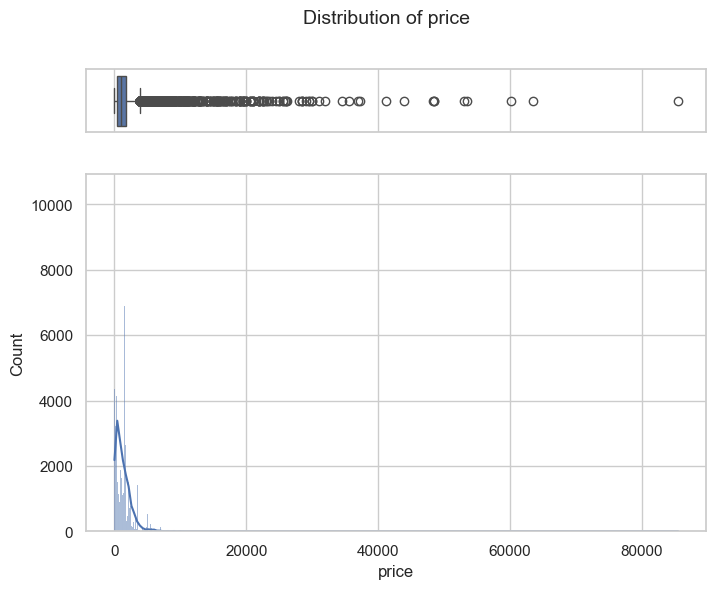

In [866]:
plot_hist_box(purchases, 'price')

**Observations:**

- The maximum price is extraordinarily high compared to the mean and median.

- This outlier might represent luxury products or incorrect data entries.

- Further investigation is needed to validate these extreme values.


In [867]:
purchases.groupby('main_category')['price'].agg(['min', 'max', 'median', 'mean', 'std'])

,min,max,median,mean,std
main_category,,,,,
1,199.0,1799.0,1799.0,1265.666667,923.760431
2,1.0,7999.0,1499.0,1608.485944,1063.656617
3,39.0,1999.0,1106.0,972.666667,812.996843
4,1.0,85499.0,1122.0,1436.420923,1524.385543
5,140.0,140.0,140.0,140.000000,NaN
5562,1.0,22999.0,599.0,880.210248,1042.690792
5963,1.0,14999.0,1120.0,1627.447134,1703.656472
6060,1.0,11199.0,214.0,393.788562,487.534093


There is a number of goods categories with uneven distributions. That might indicate a presence of luxury apparel pieces.
Since there is no domain knowledge, I will leave the price as it is.

_It might, however, be a good idea to apply log-transformation for the linear model._

**B. Aggregation**

In [868]:
price_features = purchases.groupby('client_id')['price'].agg(
    avg_price='median',
    max_price='max',
    min_price='min',
    total_expenditure='sum'
).reset_index()

In [869]:
price_features.sample(5)

,client_id,avg_price,max_price,min_price,total_expenditure
7535,1515915625488195064,319.0,319.0,319.0,319.0
30700,1515915625576134768,1632.5,1959.0,1424.0,6648.0
410,1515915625468093571,1749.0,1749.0,1749.0,1749.0
7823,1515915625488309261,799.0,799.0,799.0,799.0
48705,1515915625987803566,342.0,1399.0,85.0,5089.0


I will also add a couple of features that might improve the model's ability to predict whether a client will make a purchase within the next **90** days:

- Average Spending per 120 Days
- Total Spending within the Last 30 Days

In [870]:
TOTAL_DURATION = (purchases['date'].max() - purchases['date'].min()).days
PERIODS_120_DAYS = TOTAL_DURATION / 120

In [871]:
price_features['avg_120_days_spending'] = price_features['total_expenditure'] / PERIODS_120_DAYS

In [872]:
price_features.head()

,client_id,avg_price,max_price,min_price,total_expenditure,avg_120_days_spending
0,1515915625468060902,999.0,1999.0,199.0,4795.0,897.659906
1,1515915625468061003,2169.5,3499.0,1749.0,14135.0,2646.177847
2,1515915625468061099,299.0,299.0,299.0,299.0,55.975039
3,1515915625468061100,1049.0,1049.0,1049.0,1049.0,196.380655
4,1515915625468061170,2195.0,2699.0,999.0,14095.0,2638.689548


In [873]:
spending_30_days = (
    purchases[purchases['nr_purchases_last_30_days']==1]
    .groupby('client_id')['price']
    .sum()
    .reset_index(name='spent_last_30_days')
)

In [874]:
spending_30_days.head()

,client_id,spent_last_30_days
0,1515915625468061100,1049.0
1,1515915625468070155,5948.0
2,1515915625468085075,140.0
3,1515915625468089215,999.0
4,1515915625468096652,799.0


In [875]:
price_features = price_features.merge(spending_30_days, how='left', on='client_id')

In [876]:
price_features = price_features.fillna(0)

In [877]:
price_features.head()

,client_id,avg_price,max_price,min_price,total_expenditure,avg_120_days_spending,spent_last_30_days
0,1515915625468060902,999.0,1999.0,199.0,4795.0,897.659906,0.0
1,1515915625468061003,2169.5,3499.0,1749.0,14135.0,2646.177847,0.0
2,1515915625468061099,299.0,299.0,299.0,299.0,55.975039,0.0
3,1515915625468061100,1049.0,1049.0,1049.0,1049.0,196.380655,1049.0
4,1515915625468061170,2195.0,2699.0,999.0,14095.0,2638.689548,0.0


### 1.2.6 Features for Modelling

In [878]:
dates_features.shape

(49849, 6)

In [879]:
category_features.shape

(49848, 3)

In [880]:
quantity_features.shape

(49669, 4)

In [881]:
price_features.shape

(49669, 7)

In [882]:
purchases_features = (
    dates_features
    .merge(category_features, on='client_id', how='left')
    .merge(quantity_features, on='client_id', how='left')
    .merge(price_features, on='client_id', how='left')
)

In [883]:
purchases_features.shape

(49849, 17)

In [884]:
purchases_features.head()

,client_id,date,day_of_week,day_of_month,month,nr_purchases_last_30_days,main_category_mode,subcategory_mode,total_purchases,avg_daily_purchases,days_with_purchases,avg_price,max_price,min_price,total_expenditure,avg_120_days_spending,spent_last_30_days
0,1515915625468060902,2022-05-27,4,27,5,0,4.0,28.0,5.0,5.000000,1.0,999.0,1999.0,199.0,4795.0,897.659906,0.0
1,1515915625468061003,2023-01-04,2,4,1,0,4.0,28.0,6.0,6.000000,1.0,2169.5,3499.0,1749.0,14135.0,2646.177847,0.0
2,1515915625468061099,2022-05-17,1,17,5,0,4.0,28.0,1.0,1.000000,1.0,299.0,299.0,299.0,299.0,55.975039,0.0
3,1515915625468061100,2024-02-10,5,10,2,1,4.0,27.0,1.0,1.000000,1.0,1049.0,1049.0,1049.0,1049.0,196.380655,1049.0
4,1515915625468061170,2023-06-17,2,29,3,0,4.0,28.0,7.0,2.333333,3.0,2195.0,2699.0,999.0,14095.0,2638.689548,0.0


## 1.3 Messages

### 1.3.1 Basic Information

In [885]:
display_main_info(messages)

________________Head________________


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


None

________________Shape________________


(12739798, 7)

________________Duplicates________________


48610

________________Proportion of Missing Data________________


bulk_campaign_id    0.0
client_id           0.0
message_id          0.0
event               0.0
channel             0.0
date                0.0
created_at          0.0
dtype: float64

In [886]:
# Number of unique clients
messages['client_id'].nunique()

53329

**Observations:**

- All data types are stated correctly.

- No missing data in this data set.

- The number of exact duplicates is 48610 which will be dealt with further on.

- **Number of unique client IDs is larger than that in purchases.**

### 1.3.2 Deduplication

- The exact duplicates were likely caused by repetitive imports or merging operations.

- Such duplicates can inflate counts, totals, averages.

- Since there is no way to identify why duplicates exist I will remove them.

In [887]:
messages = messages.drop_duplicates()
messages.duplicated().sum()

0

### 1.3.2 Analysis

**A. Overview**

In [888]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [889]:
for col in messages.columns:
    print(f'Number of unique values in {col}:')
    display(messages[col].nunique())

Number of unique values in bulk_campaign_id:


2709

Number of unique values in client_id:


53329

Number of unique values in message_id:


9061667

Number of unique values in event:


11

Number of unique values in channel:


2

Number of unique values in date:


638

Number of unique values in created_at:


4103539

In [890]:
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [891]:
messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

In [892]:
messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

In [893]:
messages['channel'].value_counts(normalize=True)

channel
mobile_push    0.588635
email          0.411365
Name: proportion, dtype: float64

In [894]:
show_stats(messages, 'date')

Statics for date


,count,mean,min,25%,50%,75%,max
date,12691188,2023-06-04 17:27:00.569989632,2022-05-19 00:00:00,2022-12-16 00:00:00,2023-07-20 00:00:00,2023-11-21 00:00:00,2024-02-15 00:00:00


In [895]:
show_stats(messages, 'created_at')

Statics for created_at


,count,mean,min,25%,50%,75%,max
created_at,12691188,2023-06-05 04:38:55.658559232,2022-05-19 00:14:20,2022-12-16 19:15:55,2023-07-20 11:09:42,2023-11-21 15:58:05,2024-02-15 23:58:40


The data looks correct. I will create features that summarize the client's interaction history.

**B. Aggregation**

Message Activity
- Total messages received
- Unique campaigns the client interacted with

Event Counts
- count of each event type:
    - Positive Engagement: send, open, click, purchase
    - Negative Engagement: unsubscribe

Recency
- Time since the last interaction

Frequency
- Number of interactions in the last 30 days

Time of Interaction
- Most common day of the week
- Preferred interaction time (hour)

In [896]:
# Event Counts
messages['send'] = messages['event'].apply(lambda x: 1 if x == 'send' else 0)
messages['open'] = messages['event'].apply(lambda x: 1 if x == 'open' else 0)
messages['click'] = messages['event'].apply(lambda x: 1 if x == 'click' else 0)
messages['purchase'] = messages['event'].apply(lambda x: 1 if x == 'purchase' else 0)
messages['unsubscribe'] = messages['event'].apply(lambda x: 1 if x == 'unsubscribe' else 0)

In [897]:
# Frequency
messages['within_30_days'] = messages['date'].apply(lambda x: 1 if x >= LAST_30_DAYS else 0)

In [898]:
# Day of the week
messages['day_of_week'] = messages['date'].dt.day_of_week

In [899]:
messages_features = messages.groupby('client_id').agg(
    nr_messages=('message_id', 'nunique'),
    nr_campaigns=('bulk_campaign_id', 'nunique'),
    send=('send', 'sum'),
    open=('open', 'sum'),
    click=('click', 'sum'),
    purchase=('purchase', 'sum'),
    unsubscribe=('unsubscribe', 'sum'),
    interaction_date=('date', 'max'),
    interaction_frequency=('within_30_days', 'sum'),
    interaction_day=('day_of_week', lambda x: x.mode()[0])
)

In [900]:
messages_features.head()

,nr_messages,nr_campaigns,send,open,click,purchase,unsubscribe,interaction_date,interaction_frequency,interaction_day
client_id,,,,,,,,,,
1515915625468060902,127,127,126,35,10,5,1,2024-01-19,3,4
1515915625468061003,154,154,154,5,5,1,0,2024-02-13,4,4
1515915625468061099,215,215,215,51,8,0,0,2024-02-13,12,4
1515915625468061100,268,265,267,157,1,1,0,2024-02-15,46,3
1515915625468061170,243,240,243,31,16,3,0,2024-02-15,38,3


## 1.4 Target

In [901]:
display_main_info(target)

________________Head________________


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

________________Shape________________


(49849, 2)

________________Duplicates________________


0

________________Proportion of Missing Data________________


client_id    0.0
target       0.0
dtype: float64

In [902]:
target['target'].value_counts(normalize=True)

target
0    0.980722
1    0.019278
Name: proportion, dtype: float64

**Observations:**
The target variable is highly imbalanced, which suggests that careful attention must be given to model evaluation, and additional techniques such as class balancing may be necessary to improve model performance, especially for the minority class (target=1).

# 2 Data Preparation

## 2.1 Merging

I will merge the datasets based on the **target** shape since we have to keep everything in that dataset.

In [903]:
purchases_features.shape

(49849, 17)

In [904]:
messages_features.shape

(53329, 10)

In [905]:
target.shape

(49849, 2)

In [906]:
# Merge the features with the target variables
df = (
    target
    .merge(purchases_features, how='left', on='client_id')
    .merge(messages_features, how='left', on='client_id')
)

In [907]:
# Display all the columns
pd.set_option('display.max_columns', None)

In [908]:
df.head()

,client_id,target,date,day_of_week,day_of_month,month,nr_purchases_last_30_days,main_category_mode,subcategory_mode,total_purchases,avg_daily_purchases,days_with_purchases,avg_price,max_price,min_price,total_expenditure,avg_120_days_spending,spent_last_30_days,nr_messages,nr_campaigns,send,open,click,purchase,unsubscribe,interaction_date,interaction_frequency,interaction_day
0,1515915625468060902,0,2022-05-27,4,27,5,0,4.0,28.0,5.0,5.000000,1.0,999.0,1999.0,199.0,4795.0,897.659906,0.0,127.0,127.0,126.0,35.0,10.0,5.0,1.0,2024-01-19,3.0,4.0
1,1515915625468061003,1,2023-01-04,2,4,1,0,4.0,28.0,6.0,6.000000,1.0,2169.5,3499.0,1749.0,14135.0,2646.177847,0.0,154.0,154.0,154.0,5.0,5.0,1.0,0.0,2024-02-13,4.0,4.0
2,1515915625468061099,0,2022-05-17,1,17,5,0,4.0,28.0,1.0,1.000000,1.0,299.0,299.0,299.0,299.0,55.975039,0.0,215.0,215.0,215.0,51.0,8.0,0.0,0.0,2024-02-13,12.0,4.0
3,1515915625468061100,0,2024-02-10,5,10,2,1,4.0,27.0,1.0,1.000000,1.0,1049.0,1049.0,1049.0,1049.0,196.380655,1049.0,268.0,265.0,267.0,157.0,1.0,1.0,0.0,2024-02-15,46.0,3.0
4,1515915625468061170,0,2023-06-17,2,29,3,0,4.0,28.0,7.0,2.333333,3.0,2195.0,2699.0,999.0,14095.0,2638.689548,0.0,243.0,240.0,243.0,31.0,16.0,3.0,0.0,2024-02-15,38.0,3.0


In [909]:
df.isna().mean()

client_id                    0.000000
target                       0.000000
date                         0.000000
day_of_week                  0.000000
day_of_month                 0.000000
month                        0.000000
nr_purchases_last_30_days    0.000000
main_category_mode           0.000020
subcategory_mode             0.000020
total_purchases              0.003611
avg_daily_purchases          0.003611
days_with_purchases          0.003611
avg_price                    0.003611
max_price                    0.003611
min_price                    0.003611
total_expenditure            0.003611
avg_120_days_spending        0.003611
spent_last_30_days           0.003611
nr_messages                  0.157817
nr_campaigns                 0.157817
send                         0.157817
open                         0.157817
click                        0.157817
purchase                     0.157817
unsubscribe                  0.157817
interaction_date             0.157817
interaction_

There is a number of features with missing values. Since we cannot remove any data at this stage, I will handle those in pipelines during the modelling process. 

In [910]:
# Drop the ID column
df = df.drop('client_id', axis=1)

## 2.2 Adding new features

**A. Rates**

In [911]:
# Open rate
df['open_rate'] = df['open'] / df['send'].replace(0, np.nan)

# CTR
df['click_rate'] = df['click'] / df['open'].replace(0, np.nan)

**B. Recency**

In [912]:
df['purchase_recency'] = (PULL_DATE - df['date']).dt.days
df['interaction_recency'] = (PULL_DATE - df['interaction_date']).dt.days

In [913]:
df = df.drop(columns=['date', 'interaction_date'])

**C. Cyclic Encoding for Day of Week and Month**

This is to help the model better understand cyclic patterns.

In [914]:
df['sin_day_purch'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_day_purch'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df['sin_month_purch'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month_purch'] = np.cos(2 * np.pi * df['month'] / 12)

df['sin_day_inter'] = np.sin(2 * np.pi * df['interaction_day'] / 7)
df['cos_day_inter'] = np.cos(2 * np.pi * df['interaction_day'] / 7)

df = df.drop(columns=['day_of_week', 'month', 'interaction_day'])

**D. Log-transformation**

I will apply log transformation for the features with **highly-skewed** distributions to make the data more **normally** distributed.

Before the log-transformation.

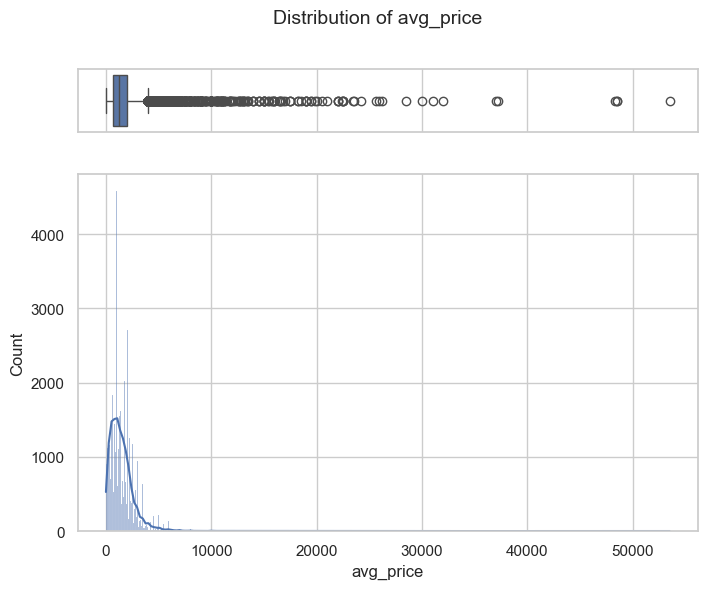

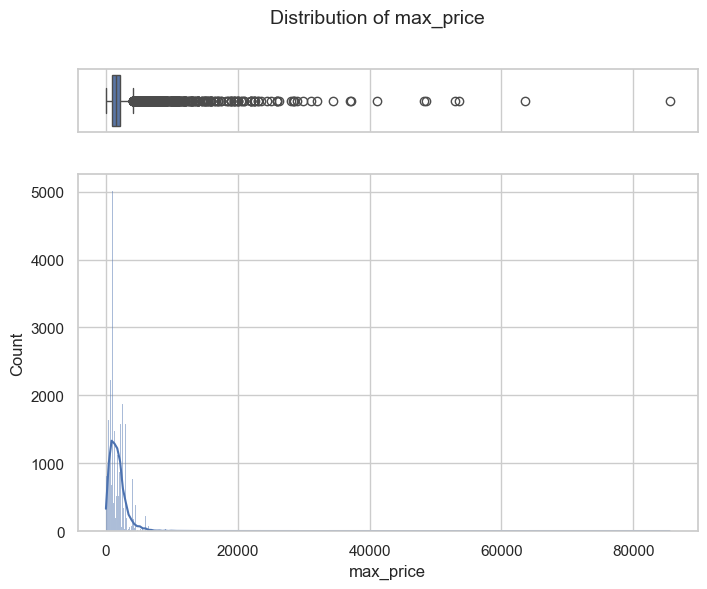

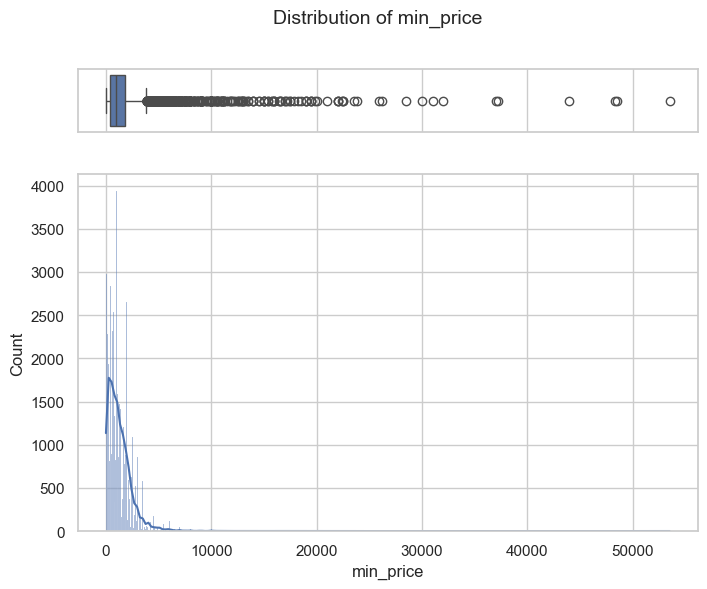

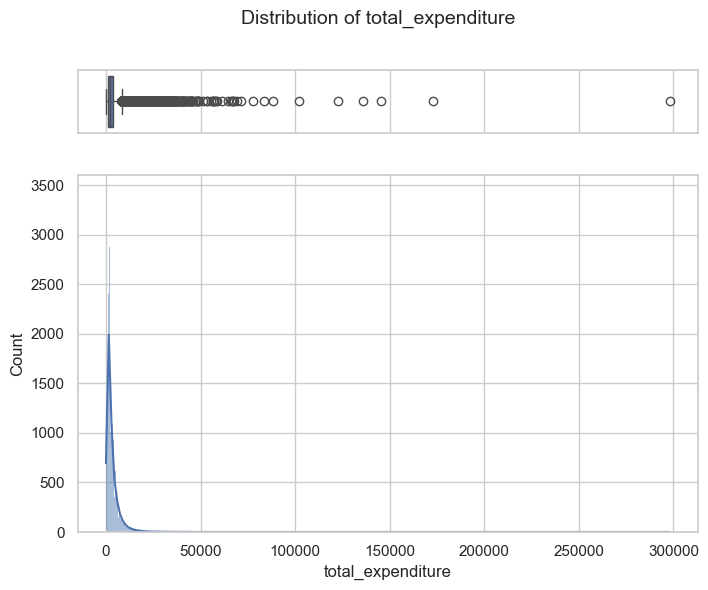

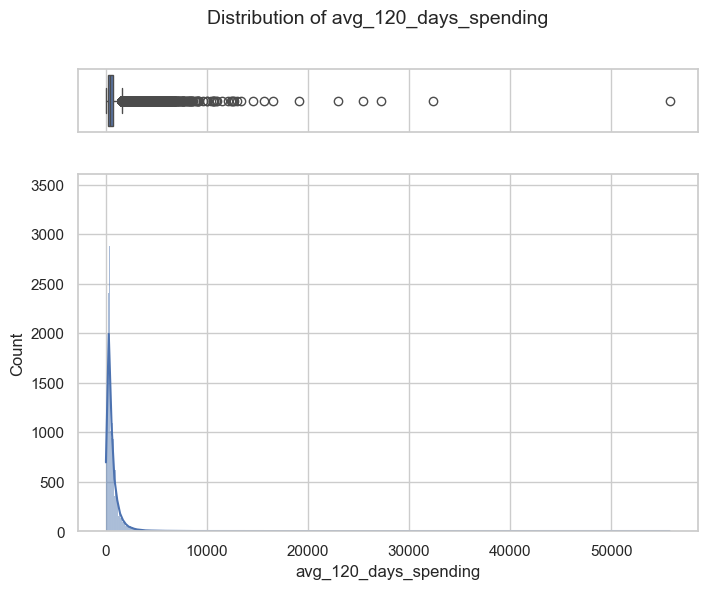

In [915]:
exp = ['avg_price', 'max_price', 'min_price', 'total_expenditure', 'avg_120_days_spending']

for col in exp:
    plot_hist_box(df, col)

In [916]:
df['avg_price'] = np.log(df['avg_price'])
df['max_price'] = np.log(df['max_price'])
df['min_price'] = np.log(df['min_price'])

In [917]:
df['total_expenditure'] = df['total_expenditure'].replace(0, np.nan)
df['total_expenditure'] = np.log(df['total_expenditure'])
df['total_expenditure'] = df['total_expenditure'].fillna(0)

In [918]:
df['avg_120_days_spending'] = df['avg_120_days_spending'].replace(0, np.nan)
df['avg_120_days_spending'] = np.log(df['avg_120_days_spending'])
df['avg_120_days_spending'] = df['avg_120_days_spending'].fillna(0)

After the log-transformation.

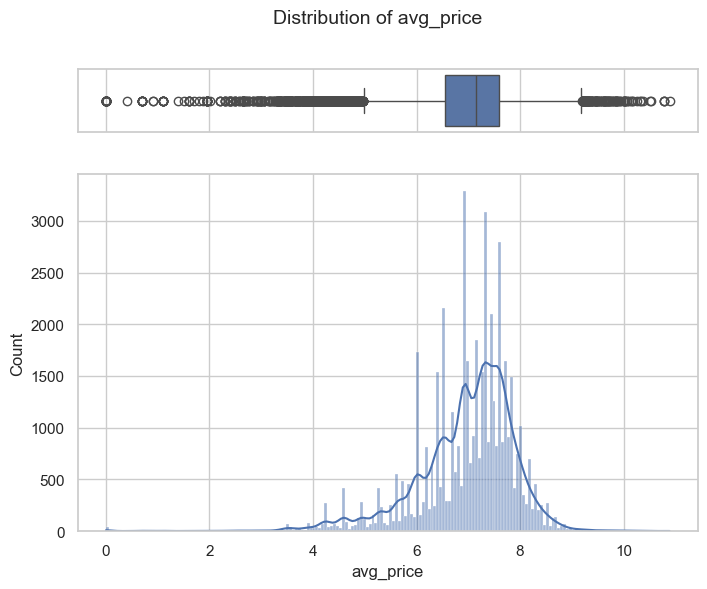

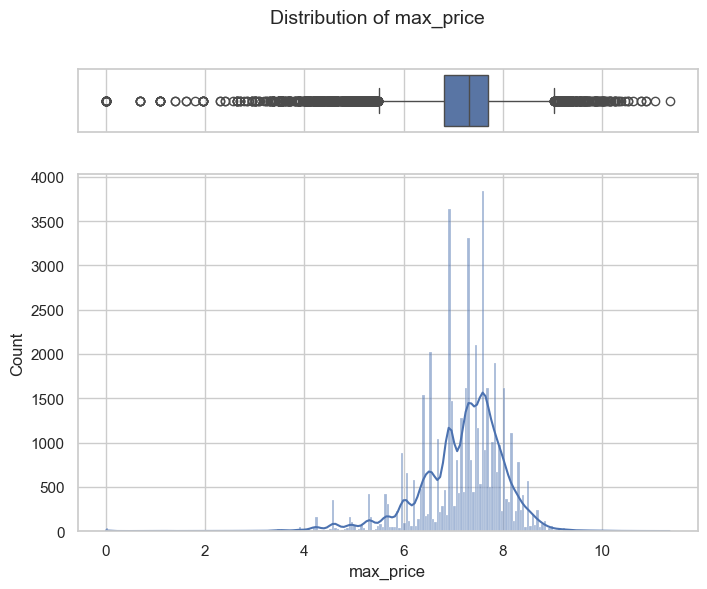

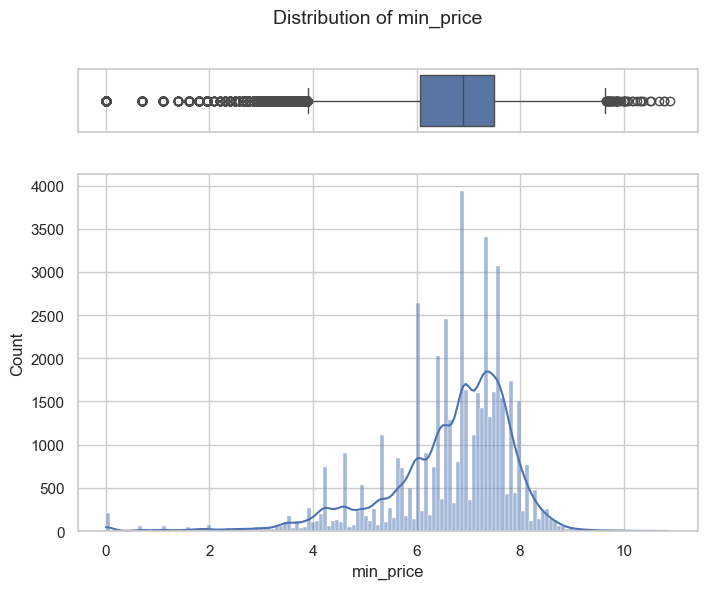

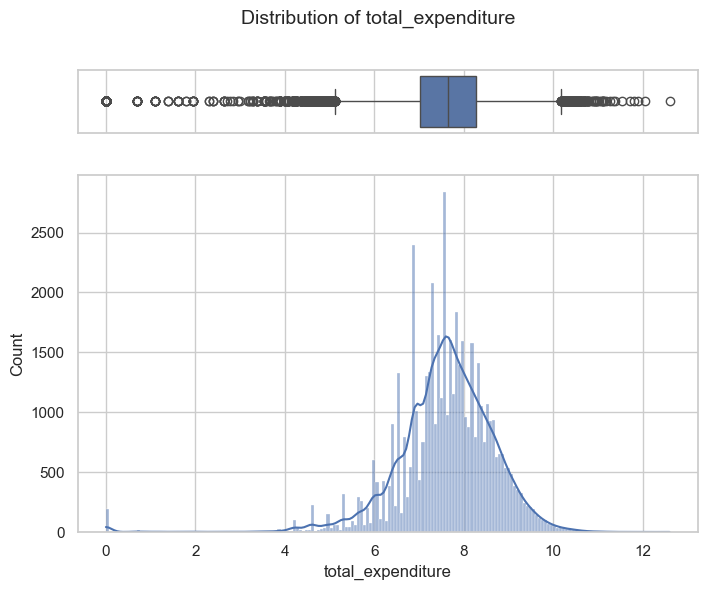

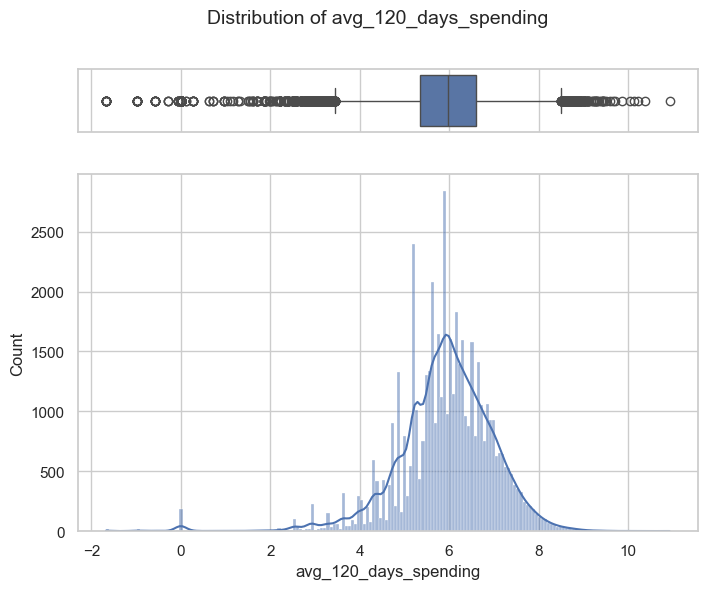

In [919]:
exp = ['avg_price', 'max_price', 'min_price', 'total_expenditure', 'avg_120_days_spending']

for col in exp:
    plot_hist_box(df, col)

**E. Binarizing**

In [920]:
df['nr_purchases_last_30_days'].value_counts(normalize=True)

nr_purchases_last_30_days
0     0.966338
1     0.015226
2     0.007523
3     0.004453
4     0.002367
5     0.001184
6     0.001023
7     0.000522
8     0.000281
9     0.000261
12    0.000160
10    0.000140
11    0.000120
16    0.000100
18    0.000040
14    0.000040
22    0.000040
23    0.000040
13    0.000040
27    0.000020
28    0.000020
17    0.000020
15    0.000020
21    0.000020
Name: proportion, dtype: float64

In [921]:
df['nr_purchases_last_30_days'] = df['nr_purchases_last_30_days'].apply(lambda x: 0 if x==0 else 1)

**F. Final Dataset**

In [922]:
# The dataset for modelling
df.head()

,target,day_of_month,nr_purchases_last_30_days,main_category_mode,subcategory_mode,total_purchases,avg_daily_purchases,days_with_purchases,avg_price,max_price,min_price,total_expenditure,avg_120_days_spending,spent_last_30_days,nr_messages,nr_campaigns,send,open,click,purchase,unsubscribe,interaction_frequency,open_rate,click_rate,purchase_recency,interaction_recency,sin_day_purch,cos_day_purch,sin_month_purch,cos_month_purch,sin_day_inter,cos_day_inter
0,0,27,0,4.0,28.0,5.0,5.000000,1.0,6.906755,7.600402,5.293305,8.475329,6.799791,0.0,127.0,127.0,126.0,35.0,10.0,5.0,1.0,3.0,0.277778,0.285714,630,28.0,-0.433884,-0.900969,0.500000,-8.660254e-01,-0.433884,-0.900969
1,1,4,0,4.0,28.0,6.0,6.000000,1.0,7.682252,8.160232,7.466799,9.556409,7.880872,0.0,154.0,154.0,154.0,5.0,5.0,1.0,0.0,4.0,0.032468,1.000000,408,3.0,0.974928,-0.222521,0.500000,8.660254e-01,-0.433884,-0.900969
2,0,17,0,4.0,28.0,1.0,1.000000,1.0,5.700444,5.700444,5.700444,5.700444,4.024906,0.0,215.0,215.0,215.0,51.0,8.0,0.0,0.0,12.0,0.237209,0.156863,640,3.0,0.781831,0.623490,0.500000,-8.660254e-01,-0.433884,-0.900969
3,0,10,1,4.0,27.0,1.0,1.000000,1.0,6.955593,6.955593,6.955593,6.955593,5.280055,1049.0,268.0,265.0,267.0,157.0,1.0,1.0,0.0,46.0,0.588015,0.006369,6,1.0,-0.974928,-0.222521,0.866025,5.000000e-01,0.433884,-0.900969
4,0,29,0,4.0,28.0,7.0,2.333333,3.0,7.693937,7.900637,6.906755,9.553575,7.878038,0.0,243.0,240.0,243.0,31.0,16.0,3.0,0.0,38.0,0.127572,0.516129,244,1.0,0.974928,-0.222521,1.000000,6.123234e-17,0.433884,-0.900969


## 2.2 Correlation Check

<Axes: title={'center': 'Features Correlation'}>

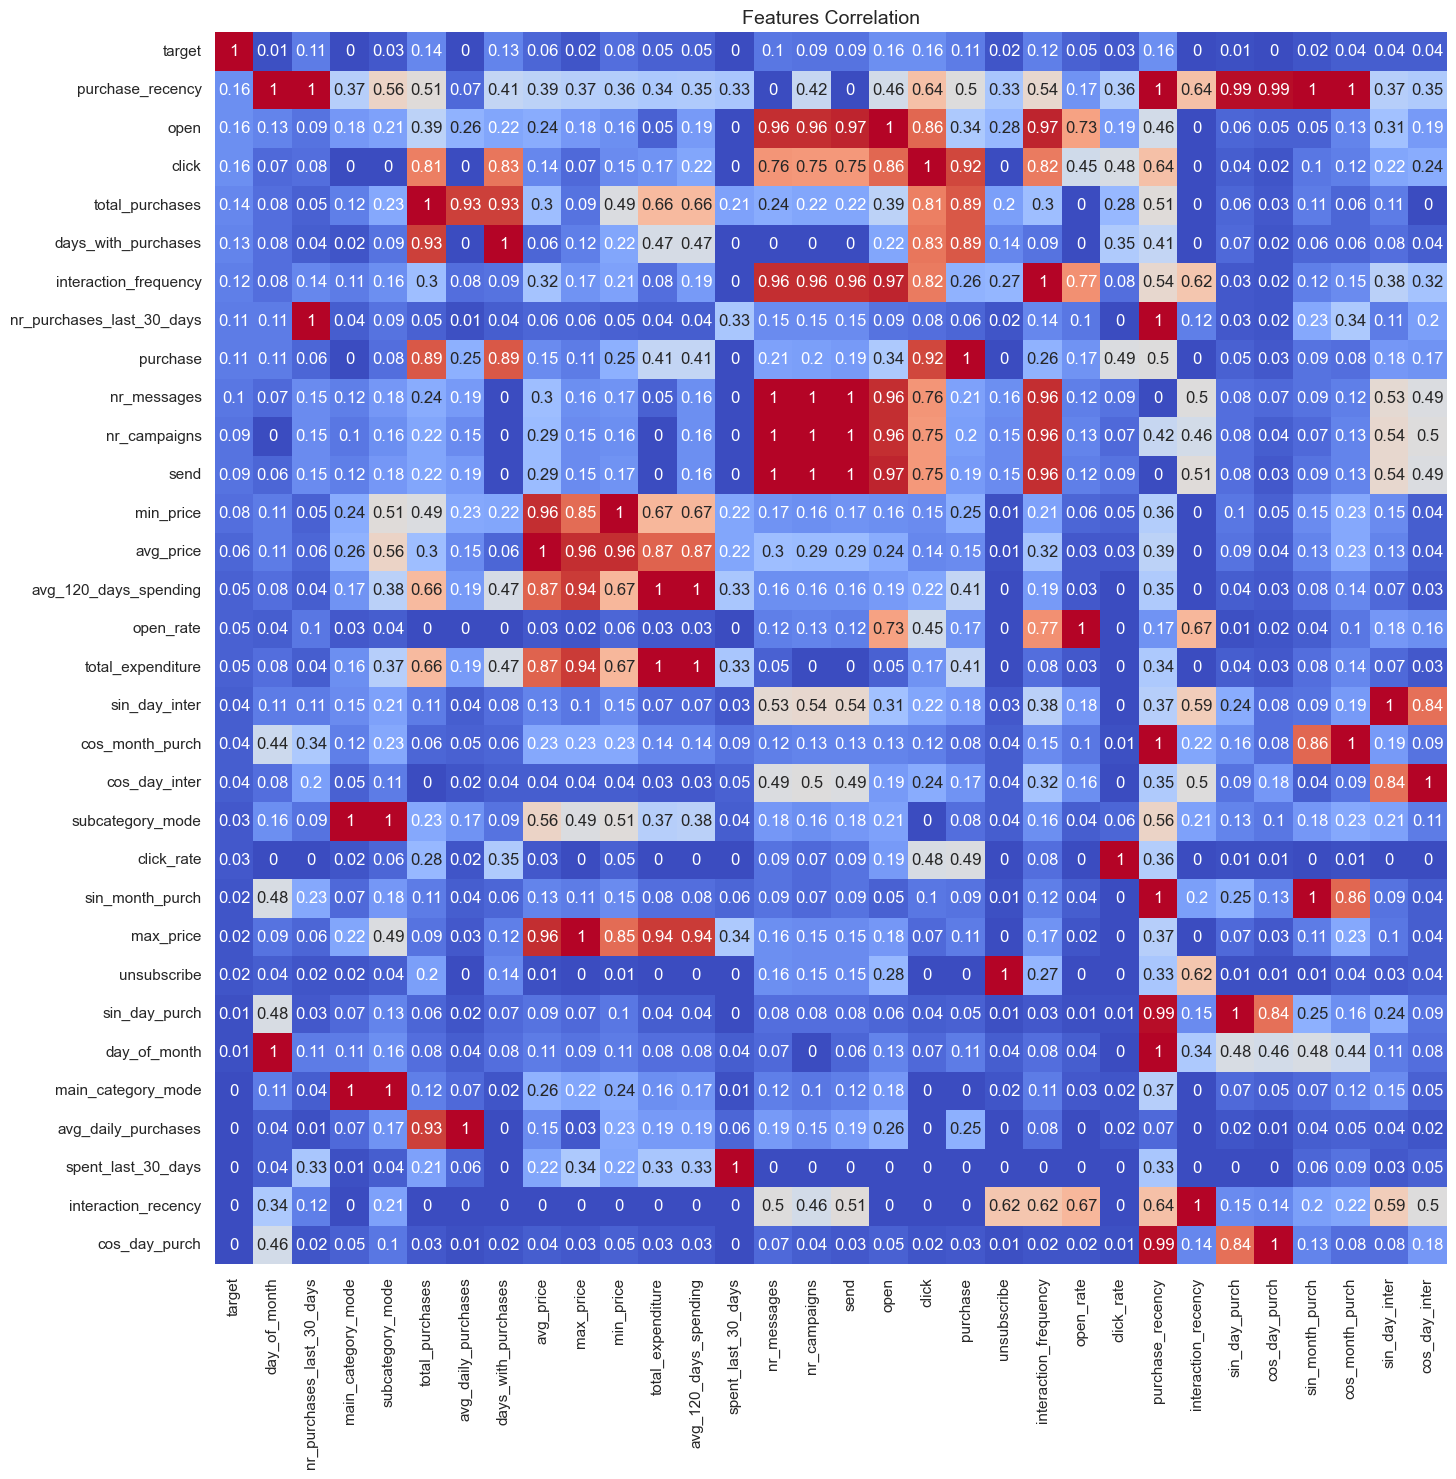

In [923]:
INTERVAL_COLS = [
    'avg_daily_purchases',
    'avg_price', 
    'max_price', 
    'min_price',
    'total_expenditure', 
    'avg_120_days_spending', 
    'spent_last_30_days',
    'open_rate',
    'click_rate', 
    'sin_day_purch', 
    'cos_day_purch', 
    'sin_month_purch', 
    'cos_month_purch',
    'sin_day_inter', 
    'cos_day_inter'
]

matrix = df.phik_matrix(interval_cols=INTERVAL_COLS).sort_values(by='target', ascending=False)
plt.figure(figsize=(16, 16))
plt.title('Features Correlation',
          fontsize=14)
sns.heatmap(matrix.round(2),
            annot = True, square=True,
            cmap='coolwarm',
            cbar=False)

**Observations:**
- The following features demonstrate a higher correlation with the target variable:
    - recency,
    - open,
    - click, 
    - total purchases,
    - days with purchases, 
    - interaction frequency
- The main category, the spending within the last 30 days and the number of daily purchases show no correlation with the target variable whatsoever.

**NB:**
- There is a number of features with extremely high correlation. 
- Since I will be testing different models, the dataset will be handled differently in each case (i.e. I will remove the highly correlated features for the linear model and keep the entire set for boosting models).

# 3 Modelling

## 3.1 Linear Model

### Modelling

I will remove highly correlated features for the Logisitc Regression classifier.

In [927]:
# Remove the features

cols_to_drop = [
    'day_of_month',
    'sin_day_purch', 
    'cos_day_purch',
    'sin_month_purch',
    'cos_month_purch',
    'nr_messages',
    'nr_campaigns',
    'send',
    'interaction_frequency',
    'avg_price',
    'max_price',
    'main_category_mode'
]

df_lr = df.drop(columns=cols_to_drop)

In [928]:
df_lr.isna().mean()

target                            0.000000
nr_purchases_last_30_days         0.000000
subcategory_mode                  0.000020
total_purchases                   0.003611
avg_daily_purchases               0.003611
days_with_purchases               0.003611
min_price                         0.003611
total_expenditure                 0.000000
avg_120_days_spending             0.000000
spent_last_30_days                0.003611
open                              0.157817
click                             0.157817
purchase                          0.157817
unsubscribe                       0.157817
open_rate                         0.157837
click_rate                        0.302955
purchase_recency                  0.000000
interaction_recency               0.157817
sin_day_inter                     0.157817
cos_day_inter                     0.157817
total_expenditure_original        0.000000
avg_120_days_spending_original    0.000000
dtype: float64

The missing values will be handled in the pipeline.

In [929]:
# Split into train and test sets

X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    df_lr.drop('target', axis=1),
    df_lr['target'],
    test_size=0.2,
    random_state=42,
    stratify=df_lr['target']
)

X_train_lin.shape, y_train_lin.shape

((39879, 21), (39879,))

In [930]:
# Define numerical features without missing values
num_features = [
    'nr_purchases_last_30_days',
    'total_expenditure',           
    'avg_120_days_spending',
    'purchase_recency' 
]

# Define numerical features requiring mean imputation
num_mean = [
    'subcategory_mode',                         
    'total_purchases',            
    'avg_daily_purchases',        
    'days_with_purchases',         
    'min_price',
    'spent_last_30_days'                                 
]

# Define numerical features requiring constant-value imputation
num_const = [
    'open',                    
    'click',                
    'purchase',                  
    'unsubscribe',                             
    'open_rate',                
    'click_rate',
    'interaction_recency',        
    'sin_day_inter',              
    'cos_day_inter'                
]

# Pipeline for features without missing values: only scaling
num = Pipeline(steps=[
    ('scaler', StandardScaler())  
])

# Pipeline for features requiring mean imputation and scaling
num_mean_pipe = Pipeline(steps=[
    ('imputer_mean', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())                      
])

# Pipeline for features requiring constant-value imputation and scaling
num_const_pipe = Pipeline(steps=[
    ('imputer_const', SimpleImputer(strategy='constant', fill_value=-1)),  
    ('scaler', StandardScaler())                                          
])

# Combine all preprocessing steps 
preprocessor = ColumnTransformer(transformers=[
    ('num', num, num_features),           
    ('num_mean', num_mean_pipe, num_mean),
    ('num_const', num_const_pipe, num_const) 
])

# Main pipeline
estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),                  
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))  
])

# Parameter grid for hyperparameter tuning
param_grid = [
    {
        'classifier': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=500)],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__class_weight': ['balanced', None],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()]
    }
]

# GridSearchCV for hyperparameter tuning
model_lin = RandomizedSearchCV(
    estimator=estimator,     
    param_distributions=param_grid,
    n_iter=8,   
    scoring='roc_auc',       
    n_jobs=-1,               
    cv=5                     
)

In [931]:
# Fit the model
model_lin.fit(X_train_lin, y_train_lin)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['nr_purchases_last_30_days',
                                                                                'total_expenditure',
                                                                                'avg_120_days_spending',
                                                                                'purchase_recency']),
                                                                              ('num_mean',
                                                                               Pipeline(steps=[('imputer_mean',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['subcategory_...
                                                                                'cos_day_inter'])])),
                                             ('classifier',
                                              LogisticRegression(random_state=42))]),
                   n_iter=8, n_jobs=-1,
                   param_distributions=[{'classifier': [LogisticRegression(max_iter=500,
                                                                           random_state=42,
                                                                           solver='liblinear')],
                                         'classifier__class_weight': ['balanced',
                                                                      None],
                                         'classifier__penalty': ['l1', 'l2'],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       RobustScaler()]}],
                   scoring='roc_auc')

In [932]:
model_lin.best_params_

{'preprocessor__num__scaler': RobustScaler(),
 'classifier__penalty': 'l2',
 'classifier__class_weight': 'balanced',
 'classifier': LogisticRegression(max_iter=500, random_state=42, solver='liblinear')}

In [933]:
print(f'Best ROC-AUC on cross validation: {model_lin.best_score_:.4f}')

Best ROC-AUC on cross validation: 0.7401


### Test Score & Confusion Matrix

ROC-AUC on test: 0.7619


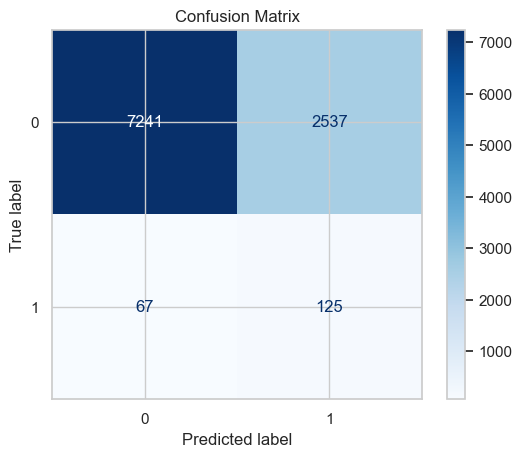

In [934]:
evaluate_model(model_lin, X_test_lin, y_test_lin)

**Conclusions:**

- The linear model the has ROC-AUC score of 0.76 on the test data, which complies with the task.

- However, even with the class imbalance handling method the model is still biased towards the majority class (class 0).

- In 2537 cases the model gives label 1 to the customers who will not make a purchase. And only in 125 cases predicts the class 1 correctly.

## 3.2 Gradient Boosting Models

### CatBoost & LGBM

For the gradient boosting models I will use the entire dataset, since tree-based models can successfully handle highly correlated features.

In [935]:
target = df['target']
features = df.drop('target', axis=1)

In [936]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    stratify=target,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((39879, 33), (9970, 33))

In [937]:
# Define the pipeline
estimator = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('classifier', LGBMClassifier(learning_rate=0.1)) 
])

# Define parameter grid for RandomizedSearchCV
params = [
    {
        'classifier': [LGBMClassifier(learning_rate=0.1, verbose=0)],
        'classifier__n_estimators': [50, 100, 200]
    },
    {
        'classifier': [CatBoostClassifier(learning_rate=0.1, verbose=0)],
        'classifier__iterations': [50, 100, 200]
    }
]

# Set up RandomizedSearchCV
model = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=6,  
    scoring='roc_auc',  
    cv=5,  
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Fit the RandomizedSearchCV object
model.fit(X_train, y_train) 

# Print the best parameters and score
print("Best Parameters:", model.best_params_)
print("Best ROC-AUC Score:", model.best_score_)


Best Parameters: {'classifier__iterations': 100, 'classifier': <catboost.core.CatBoostClassifier object at 0x1e4c2d250>}
Best ROC-AUC Score: 0.7481550267147451


### CatBoost Tuning

In [938]:
# Split the dataset
target = df['target']
features = df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    stratify=target, 
    random_state=RANDOM_STATE
)

# Define the pipeline
estimator = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('classifier', CatBoostClassifier(auto_class_weights='SqrtBalanced', random_seed=123, verbose=0)) 
])

# Define parameter grid for RandomizedSearchCV
params = [
    {
        'classifier__depth': [4, 6],
        'classifier__learning_rate': [0.03, 0.06, 0.1],
        'classifier__iterations': [50, 100, 150, 200],
        'classifier__early_stopping_rounds': [50]
    }
]

# Set up RandomizedSearchCV
model_boost = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=20,  
    scoring='roc_auc',  
    cv=5,  
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Fit the RandomizedSearchCV object
model_boost.fit(X_train, y_train) 

# Print the best parameters and score
print("Best Parameters:", model_boost.best_params_)
print("Best ROC-AUC Score:", model_boost.best_score_)

Best Parameters: {'classifier__learning_rate': 0.06, 'classifier__iterations': 150, 'classifier__early_stopping_rounds': 50, 'classifier__depth': 4}
Best ROC-AUC Score: 0.7528869621812602


ROC-AUC on test: 0.7654


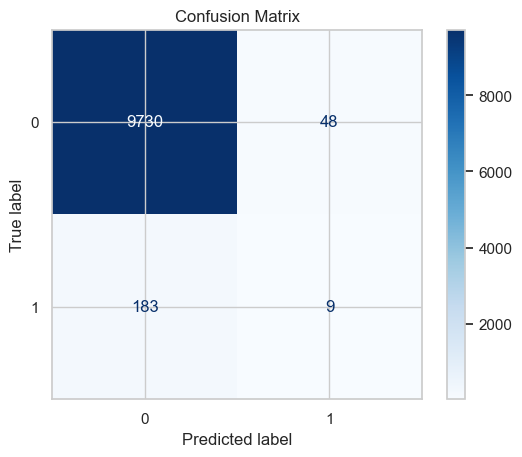

In [939]:
evaluate_model(model_boost, X_test, y_test)

**Conclusions:**
- The gradient boosting model the has ROC-AUC score of 0.76 on the test data, which complies with the task.

- However, even with the class imbalance handling method the model is still biased towards the majority class (class 0).

- Model correctly identifies 8 clients who will make a purchase.

**Key Factors in Model Selection - Resources for Campaigns and Targeting** 

For this given project I will assume that the campaigns are relatively inexpensive (e.g., we only have emails or push notifications), so I will also compare **Recall** (to capture more potential buyers).

In [940]:
# Linear Model
recall_linear = calculate_recall(model_lin, X_test_lin, y_test_lin)

Recall on test: 0.6510


In [941]:
# CatBoost
calculate_recall(model_boost, X_test, y_test)

Recall on test: 0.0469


**Conclusions:**

The **Linear** Model demonstrates a **much** better Recall score. Which is why it would be better to use it to analyze potential buyers.

# 4 Feature Importance

**A. Overview of each feature importance**

In [942]:
best_model = model_lin.best_estimator_  
classifier = best_model.named_steps['classifier'] 
preprocessor = best_model.named_steps['preprocessor']  

num_features_all = num_features + num_mean + num_const 
feature_names = num_features_all 

coefficients = classifier.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
0,nr_purchases_last_30_days,0.956359
3,purchase_recency,0.560349
1,total_expenditure,0.429140
2,avg_120_days_spending,0.410044
16,interaction_recency,0.302784
13,unsubscribe,0.289935
7,days_with_purchases,0.250737
11,click,0.241042
14,open_rate,0.236781
8,min_price,0.215774


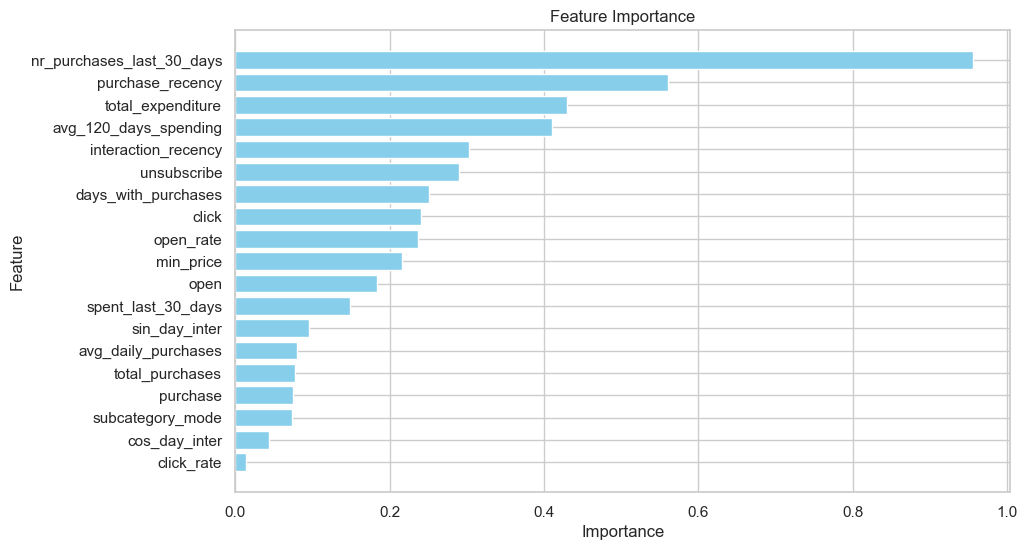

In [943]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.show()

**Observations - The Top Five Features:**

- It appears that the most significant features contain information whether a client has been recently active.

- The features reflecting an average total expenditure and an average 120-day expenditure are also among the top five features.

- Surprisingly, the features related to the number of purchases and the day of the purchase are much less important.

# 5 Customers Analysis

Here I will analyze the dependency of the predicted probabilities on top five features.

In [944]:
predictions_lin = model_lin.predict_proba(X_test_lin)[:, 1]
df = X_test_lin.copy()
df['predictions'] = predictions_lin
df.head()

,nr_purchases_last_30_days,subcategory_mode,total_purchases,avg_daily_purchases,days_with_purchases,min_price,total_expenditure,avg_120_days_spending,spent_last_30_days,open,click,purchase,unsubscribe,open_rate,click_rate,purchase_recency,interaction_recency,sin_day_inter,cos_day_inter,total_expenditure_original,avg_120_days_spending_original,predictions
11908,0,28.0,2.0,2.0,1.0,7.392032,8.166784,6.491247,0.0,61.0,42.0,2.0,0.0,0.242063,0.688525,457,1.0,-0.433884,-0.900969,3522.0,659.344774,0.468652
5270,0,18.0,3.0,1.5,2.0,6.549651,8.388678,6.713140,0.0,159.0,3.0,3.0,0.0,0.394541,0.018868,388,1.0,0.433884,-0.900969,4397.0,823.151326,0.567531
16109,0,5634.0,2.0,2.0,1.0,5.141664,5.932245,4.256707,0.0,25.0,3.0,1.0,0.0,0.252525,0.120000,260,1.0,0.433884,-0.900969,377.0,70.577223,0.451263
19528,0,5631.0,1.0,1.0,1.0,6.549651,6.549651,4.874113,0.0,0.0,7.0,1.0,0.0,0.000000,NaN,48,1.0,0.781831,0.623490,699.0,130.858034,0.524783
28294,0,28.0,2.0,2.0,1.0,6.395262,7.242798,5.567260,0.0,0.0,17.0,2.0,0.0,0.000000,NaN,134,2.0,-0.433884,-0.900969,1398.0,261.716069,0.473538


**A. Purchase & Interaction Recency**

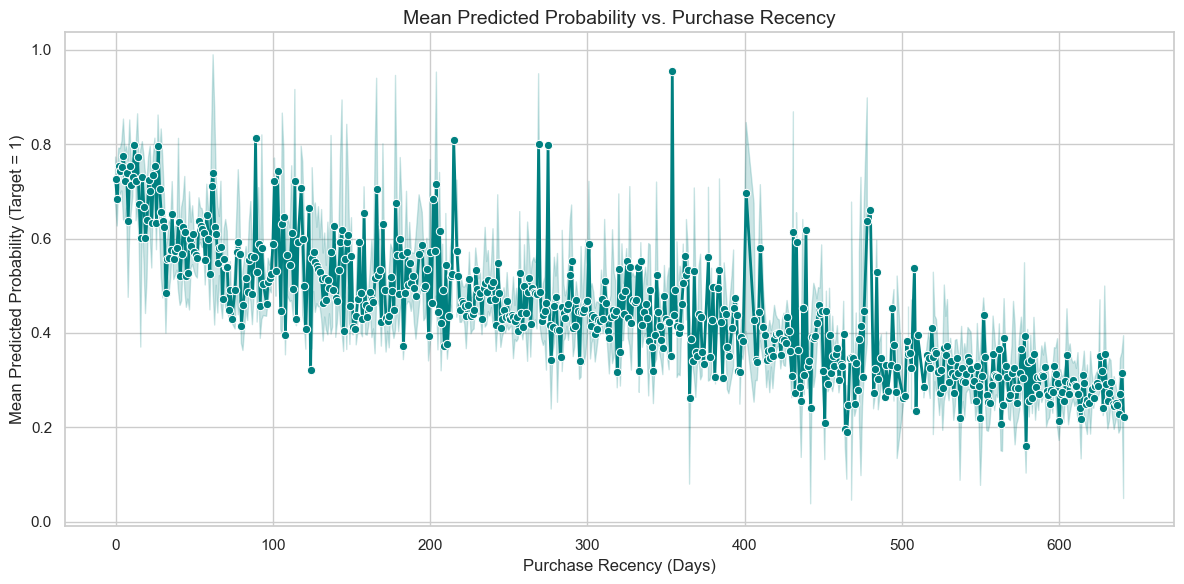

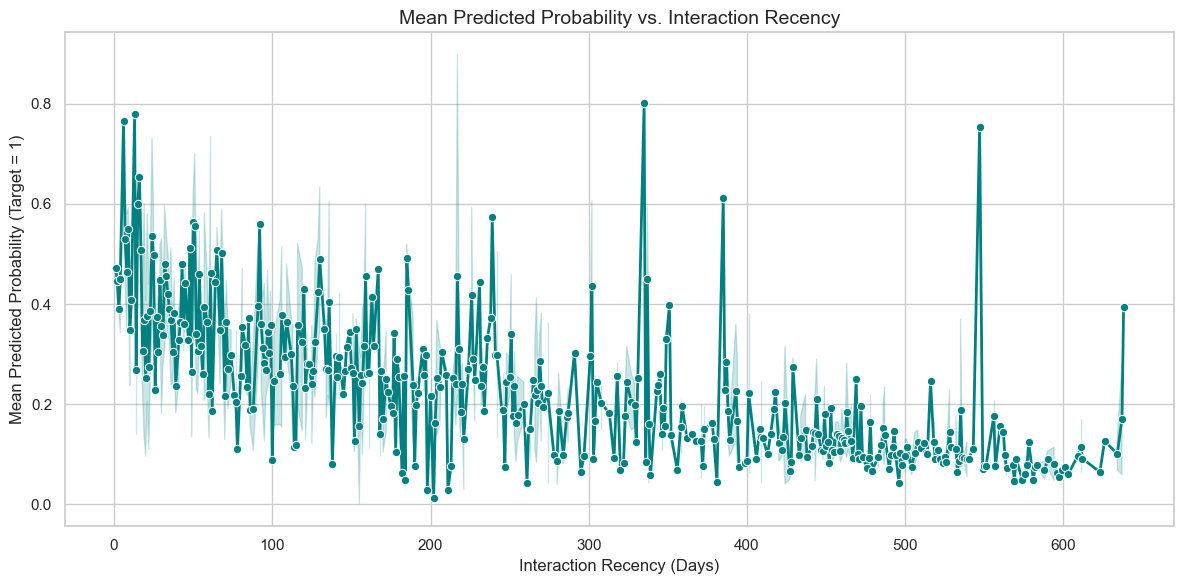

In [945]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df,
    x='purchase_recency',
    y='predictions',
    marker='o',
    linewidth=2,
    color='teal'
)

plt.title('Mean Predicted Probability vs. Purchase Recency', fontsize=14)
plt.xlabel('Purchase Recency (Days)', fontsize=12)
plt.ylabel('Mean Predicted Probability (Target = 1)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df,
    x='interaction_recency',
    y='predictions',
    marker='o',
    linewidth=2,
    color='teal'
)

plt.title('Mean Predicted Probability vs. Interaction Recency', fontsize=14)
plt.xlabel('Interaction Recency (Days)', fontsize=12)
plt.ylabel('Mean Predicted Probability (Target = 1)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Here it can be seen that there is a somewhat linear correlation between the recency of the last purchase/interaction and the probability.
I would appear that the customers who were active within the last 50 days are more likely to return.

The number of marketing campaigns a client unsubscribed from is nearly as important as the interaction. Let's have a loot at that as well.

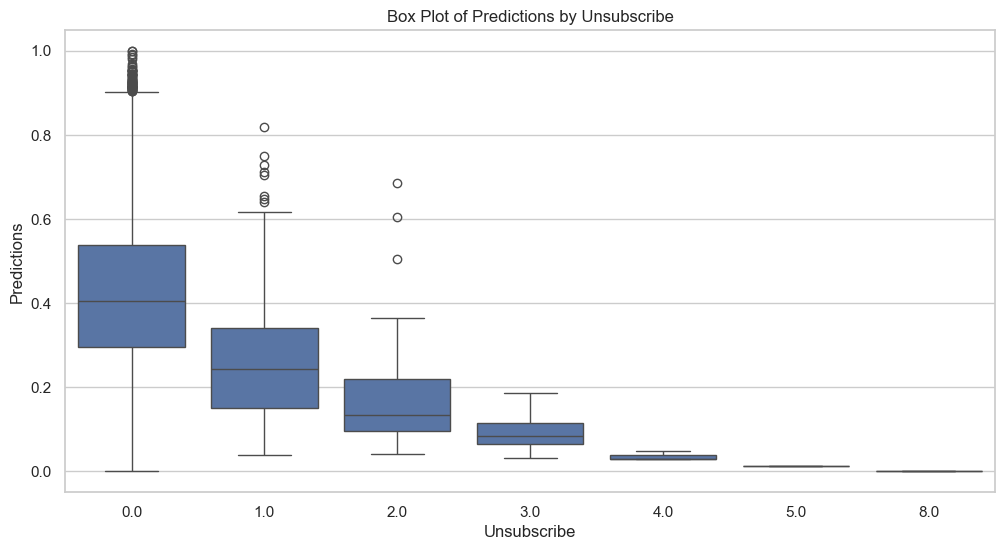

In [946]:

df_cleaned = df.dropna(subset=['unsubscribe'])
agg_data = df_cleaned.groupby('unsubscribe')['predictions'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(x='unsubscribe', y='predictions', data=df_cleaned)
plt.xlabel('Unsubscribe')
plt.ylabel('Predictions')
plt.title('Box Plot of Predictions by Unsubscribe')
plt.show()

Again, it's quite logical that clients who never unsubscribed from the campaigns are more likely to return.

**B. Expenditure**

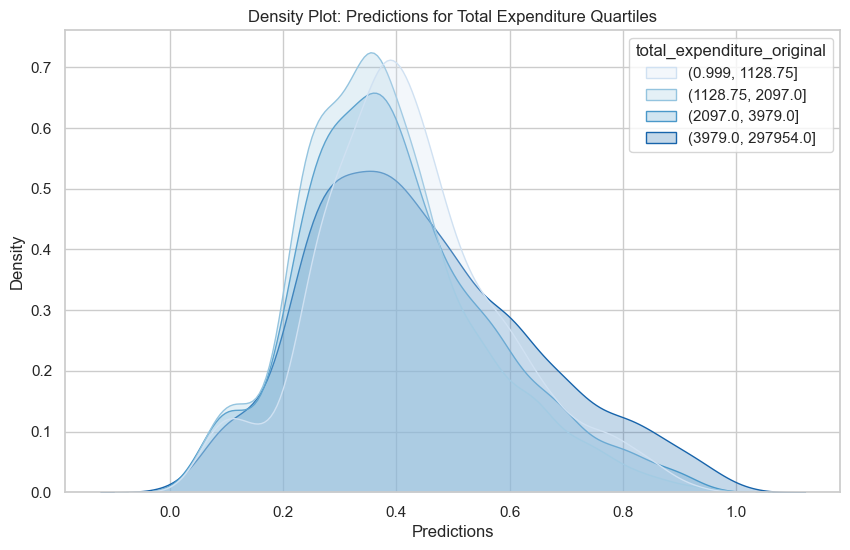

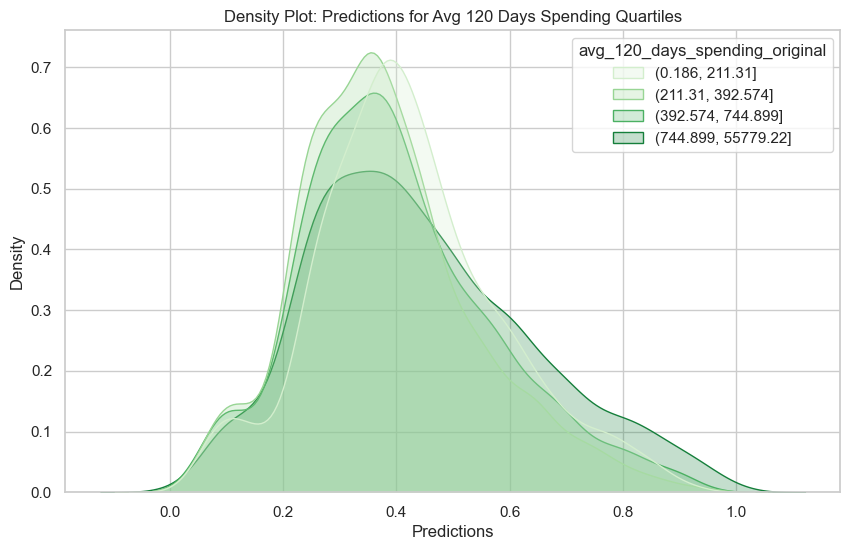

In [947]:
df['total_expenditure_original'] = np.exp(df['total_expenditure'])
df['avg_120_days_spending_original'] = np.exp(df['avg_120_days_spending'])

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='predictions', hue=pd.qcut(df['total_expenditure_original'], q=4), palette='Blues', fill=True)
plt.xlabel('Predictions')
plt.ylabel('Density')
plt.title('Density Plot: Predictions for Total Expenditure Quartiles')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='predictions', hue=pd.qcut(df['avg_120_days_spending_original'], q=4), palette='Greens', fill=True)
plt.xlabel('Predictions')
plt.ylabel('Density')
plt.title('Density Plot: Predictions for Avg 120 Days Spending Quartiles')
plt.show()

I would appear that probabilities are higher for the customers who spent on average 1130-2100 in total and 211-390 within the last 120 days.

# 6 Conclusion

**Conclusions**:

The marketing team should focus on the following customers who:

- have been active within the last 30-50 days, i.e.
    - made purchases,
    - received a marketing campaign
    - didn't unsubscribe.

- has spent on average 1130-2100 in total

- has spent on average 211-390 within the last 120 days.

In [948]:
!pip freeze > requirements.txt